# Detect Any Sound Model (DASM)
Here is a sample script that runs the detect any sound model.

In [1]:
import os

import numpy as np
import torch

os.system('export CUDA_VISIBLE_DEVICES=2')
device = 'cuda'
root_path = "/home/cpf/code/open/Transformer4SED" # change to your own path
%cd root_path

/home/cpf/code/open/Transformer4SED


Load the MGA-CLAP model as the query generation module.

In [2]:
%cd third_parties/MGA-CLAP
from models.ase_model import ASE
import yaml

config_path = "settings/inference_sed.yaml"

with open(config_path, "r") as f:
    config = yaml.safe_load(f)
clap_weight_path = config["eval"]["ckpt"]
clap = ASE(config)
clap = clap.to(device)
clap.load_state_dict(torch.load(clap_weight_path)['model'], strict=False)

/home/cpf/code/MGA-CLAP


/home/cpf/env/anaconda3/envs/AST-SED/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


_IncompatibleKeys(missing_keys=[], unexpected_keys=['text_encoder.text_encoder.embeddings.position_ids'])

Load audio encoder and decoder.

In [3]:
%cd /home/cpf/code/open/Transformer4SED

from src.utils import load_yaml_with_relative_ref
from src.models.detect_any_sound.detect_any_sound_htast import DASM_HTSAT

# Using DASM with text queries as the example
weight_path = "./pretrained_model/detect_any_sound/text_query/as_full_text_query_best_model.pt"
config_path = "./pretrained_model/detect_any_sound/text_query/config.yaml"
query_type = 'text'
configs = load_yaml_with_relative_ref(config_path)
detect_any_sound_model = DASM_HTSAT(**configs["DASM_HTSAT"]["init_kwargs"])
detect_any_sound_model.load_state_dict(torch.load(weight_path))
detect_any_sound_model = detect_any_sound_model.to(device)

/home/cpf/code/open/Transformer4SED


## Inference

Load examples
- Y69AIBPnJN5E.wav
- Y9MWHXCLAX8I.wav
- Y8XpFjwhNYUE.wav


In [4]:
from src.preprocess.feats_extraction import waveform_modification
from src.codec.encoder import Encoder


detect_any_sound_model.eval()
encoder = Encoder(
    [],
    audio_len=configs["feature"]["audio_max_len"],
    frame_len=configs["feature"]["win_length"],
    frame_hop=configs["feature"]["hopsize"],
    net_pooling=configs["feature"]["net_subsample"],
    sr=configs["feature"]["sr"],
)

dataset_path = "/home/cpf/data/audioset_strong/val_32k_real/"
audio_name = "Y69AIBPnJN5E.wav"
audio_path = os.path.join(dataset_path, audio_name)
wav, pad_mask = waveform_modification(audio_path, encoder.audio_len * encoder.sr, encoder)
wav = wav.unsqueeze(0).to(device)  # add a batch dimension
extractor = detect_any_sound_model.get_feature_extractor()
mel = extractor(wav)

In [5]:
from IPython.display import Audio
Audio(data=wav.cpu().squeeze(0), rate=32000)

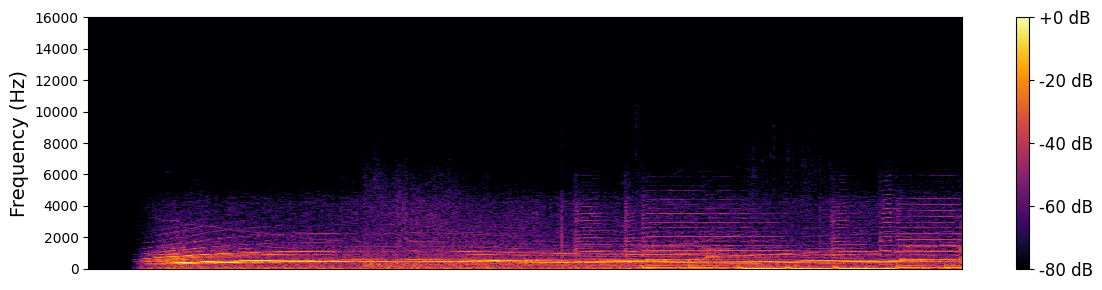

In [6]:
import matplotlib.pyplot as plt
import librosa
import librosa.display

def plot_spectrogram(wav: torch.Tensor, sr: int, n_fft: int = 2048, hop_length: int = 512, win_length: int = 2048):
    wav_np = wav.squeeze().cpu().numpy()
    
    D = librosa.stft(wav_np, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    D_db = librosa.amplitude_to_db(np.abs(D), ref=np.max) 
    
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(D_db, sr=sr, y_axis='hz', cmap='inferno')
    plt.ylabel('Frequency (Hz)', fontsize=14)

    cbar = plt.colorbar(format='%+2.0f dB')
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout()
    plt.show()

plot_spectrogram(wav, sr=encoder.sr)

get prompts

In [7]:
import torch.nn.functional as F
import torch.nn as nn

def custom_queries(class_list):
    # Add prompt
    prompt = 'sound of '
    queries = [prompt + x.lower() for x in class_list]
    with torch.no_grad():
        # compute text embeddings from natural text
        _, word_embeds, attn_mask = clap.encode_text(queries)
        text_embeds = clap.msc(word_embeds, clap.codebook, attn_mask)
        text_embeds = F.normalize(text_embeds, dim=-1)
        print("shape of text embeddings is {0}".format(text_embeds.shape))
    return text_embeds


def get_att_mask(query_len, base_len):
    att_mask = torch.ones(query_len, query_len, dtype=torch.bool).to(device)
    att_mask[:, :base_len] = False
    att_mask.fill_diagonal_(False)  # fill diagonal in place
    return att_mask


def load_base_query(dasm_model:DASM_HTSAT, query_type):
    if not isinstance(detect_any_sound_model.at_query, nn.ParameterList):
        return detect_any_sound_model.at_query
    elif query_type == 'text':
        return detect_any_sound_model.at_query[0]
    elif query_type == 'audio':
        return detect_any_sound_model.at_query[1]
    else:
        raise RuntimeError('You must assign a type to query. Supported types are \'text\' and \'audio\'.')

############## Chnage the query to whatever you want to detect ###################
query_list = ['alarm', 'sirens', 'air raid sirens', 'dog', 'music', 'bird']
#################################################################################

query_vectors = custom_queries(query_list)
base_vector = load_base_query(detect_any_sound_model, query_type)
print(base_vector.shape)
base_size = len(base_vector)

query = torch.cat([base_vector, query_vectors]).to(device)
att_mask = get_att_mask(query.shape[0], base_size)

shape of text embeddings is torch.Size([6, 1024])
torch.Size([407, 1024])


In [8]:
strong, weak, other_dict = detect_any_sound_model(
    input=mel,
    temp_w=0.5,
    pad_mask=pad_mask.unsqueeze(0),
    query=query,
    query_type=query_type,
    tgt_mask=att_mask,
)

# strong = strong / other_dict['at_out'].unsqueeze(-1) # Optional

## 3 Visualization

In [9]:
from typing import List
import matplotlib.pyplot as plt


def plot_prediction(
        matrix: np.ndarray,
        label_list: List[str],
        figsize=(12, 4),
):
    assert matrix.shape[0] == len(label_list)
    # add margin between lines
    matrix_with_spacing = []
    for row in matrix:
        matrix_with_spacing.append(row)
        matrix_with_spacing.append(np.zeros_like(row))  # 添加一个空白行
    matrix_with_spacing = np.array(matrix_with_spacing)

    # plotting
    # fig, ax = plt.subplots(figsize=(12, 0.4 * len(label_list)))
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(
        matrix_with_spacing,
        aspect='auto',
        cmap='viridis',
        interpolation='none',
    )
    # add color bar
    cbar = fig.colorbar(cax, ax=ax)
    # cbar.set_label('Probability')
    # set caption
    # ax.set_title('Probability of Queried Events')
    ax.set_xlabel('Time (s)')
    # ax.set_ylabel('query', fontsize=14)

    # set x-axi
    ax.set_xticks(np.arange(0, 550, 50))
    ax.set_xticklabels(np.arange(0, 11, 1), fontsize=12)

    # set y-axi
    yticks_positions = np.arange(0, len(label_list) * 2, 2)
    ax.set_yticks(yticks_positions)
    ax.set_yticklabels(label_list, fontsize=10)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

alarm:  0.94
sirens:  0.92
air raid sirens:  0.78
dog:  0.25
music:  0.79
bird:  0.11


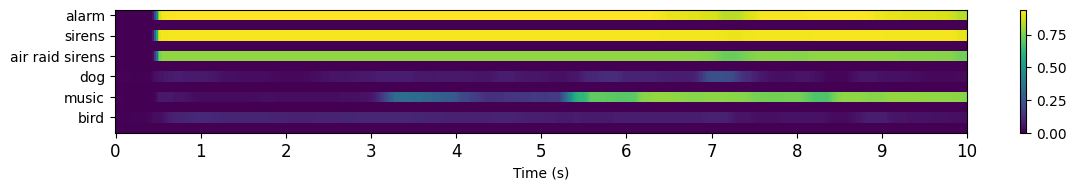

In [12]:
import scipy

def median_filter(score_matrix, filter_size=16):
    ret = np.zeros_like(score_matrix)
    for i in range(len(score_matrix)):
        ret[i, :] = scipy.ndimage.median_filter(score_matrix[i, :], filter_size)
    return ret



strong_scores = strong.squeeze(0)[base_size:].detach().cpu().numpy()
at_scores = other_dict['at_out'].squeeze(0)[base_size:].detach().cpu().numpy()
strong_matrix_processed = median_filter(strong_scores)

# show audio tagging results
for i in range(len(query_list)):
    print(f'{query_list[i]}:  {at_scores[i]:.2f}')

plot_prediction(
    strong_matrix_processed,
    query_list,
    figsize=(12, 2),
)